In [1]:
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from qutip.expect import expect
import numpy as np
from samplers_util import thermal_rejection
import matplotlib.pyplot as plt
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:

import os

#Move the directory back to Duke_Data
#Check if the current directory is Duke_Data
if os.getcwd().split('/')[-1] != 'DUKE_ANALOG_ZNE_DATA':
    #os.chdir('Duke_Data')
    os.chdir('../')
    #print(os.getcwd().split('/')[-1])
    #pass
else:
    pass
print(os.getcwd())
from index import print_index, get_experiment, index_folder
from functions_util import cetina_thermal_exp, cetina_envelope_exp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import h5py
from fitting_functions_ZNE import linear_ZNE, third_no_first_ZNE


/Users/thomassteckmann/Duke_Analog_ZNE_data


In [3]:
# import all the useful lib in python
from matplotlib import artist as art
%matplotlib inline
import scipy as sp
# import pandas as pd
import pathlib
import os
import datetime as dt
import glob
from IPython.display import clear_output
from numpy.fft import fft, ifft

from h5analysis import *
from qsim_functions import*


In [4]:
#Pairs:
# wait_times = [0.000000, 0.119841, 0.359523, 0.719045, 0.958727, 1.198409, 1.797613, 2.396818, 3.595226]
# data_names = ['000558346','000558347','000558348','000558349','000558350','000558352']
# data_folder = 'Jij_Extrapolation'
data_names = ['217', '218', '219', '220', '221', '222', '223', '224', '225']
wait_times = [0.000000, 0.096831, 0.290494, 0.580987, 0.774650, 0.968312, 1.452468, 1.936624, 2.904936]
data_folder = 'ROUND_2_JIJ_MITIGATION'

pair = (12,13)
theta_0 = 0.056737213516413414
theta_dot = 0.024506055212502265
shots = 600
converter = 1/409.6
theta_list = theta_0+ theta_dot*np.array(wait_times)*converter*1e3
full_data_folder_path = './data/' + data_folder + '/'
for name_index in range(len(data_names)):
    name = data_names[name_index]
    if '000563' in name:
        pass
    else:
        name = '000563' + name
        data_names[name_index] = name
        

In [5]:
print()
COUNTS_THRESHOLD = 1

print(os.getcwd())



/Users/thomassteckmann/Duke_Analog_ZNE_data


In [6]:
results = np.zeros((len(data_names), 30))
leakage_matrix = np.zeros((30, len(data_names)))
flopping_matrix = np.zeros((30, len(data_names)))
flopping_std_matrix = np.zeros((30, len(data_names)))
times = None

for file_id_index in range(len(data_names)):
    file_id = data_names[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    print(counts.shape)
    measurements = np.zeros((2, shots, 30))
    for pair_index in range(len(pair)):
        qubit = pair[pair_index]
        measurements[pair_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((shots, 30), dtype='<U5')
    expectations = np.zeros((shots, 30))
    for i in range(shots):
        for j in range(30):
            expectation = ((measurements[0,i,j]*2-1) - (measurements[1,i,j]*2-1))/2
            bitstring = str(int(measurements[0,i,j])) + str(int(measurements[1,i,j]))
            #print(bitstring)
            counts_bitstrings[i,j] = bitstring
            expectations[i,j] = expectation
    #average expectations across the 150 axis:
    expectations_avg = np.mean(expectations, axis=0)
    #Convert counts_bitstrings to a dictionary of counts
    print(counts_bitstrings)
    counts_array  = np.zeros((30,), dtype=dict)
    for i in range(30):
        counts_array[i] = {}
        for j in range(shots):
            if counts_bitstrings[j,i] in counts_array[i]:
                counts_array[i][counts_bitstrings[j,i]] += 1
            else:
                counts_array[i][counts_bitstrings[j,i]] = 1
                
    leakage = np.zeros((30,))
    for i in range(30):
        if '00' in counts_array[i]:
            leakage[i] = counts_array[i]['00']/shots
        if '11' in counts_array[i]:
            leakage[i] += counts_array[i]['11']/shots
    leakage_conv = np.zeros((30,))
    for i in range(30):
        leakage_conv[i] = np.mean(leakage[i:i+3])
    leakage_matrix[:,file_id_index] = leakage#leakage_conv
    flopping_matrix[:,file_id_index] = expectations_avg
    flopping_std = np.std(expectations, axis=0)
    flopping_std_matrix[:,file_id_index] = flopping_std

[0.         0.08413281 0.16826563 0.25239844 0.33653125 0.42066406
 0.50479688 0.58892969 0.6730625  0.75719531 0.84132812 0.92546094
 1.00959375 1.09372656 1.17785937 1.26199219 1.346125   1.43025781
 1.51439063 1.59852344 1.68265625 1.76678906 1.85092188 1.93505469
 2.0191875  2.10332031 2.18745313 2.27158594 2.35571875 2.43985156]
(23, 600, 30)


[['10' '10' '10' ... '01' '01' '11']
 ['10' '10' '11' ... '10' '01' '10']
 ['10' '10' '10' ... '01' '11' '00']
 ...
 ['10' '10' '11' ... '10' '01' '10']
 ['10' '10' '01' ... '10' '11' '01']
 ['10' '01' '10' ... '10' '01' '11']]
[0.         0.08413281 0.16826563 0.25239844 0.33653125 0.42066406
 0.50479688 0.58892969 0.6730625  0.75719531 0.84132812 0.92546094
 1.00959375 1.09372656 1.17785937 1.26199219 1.346125   1.43025781
 1.51439063 1.59852344 1.68265625 1.76678906 1.85092188 1.93505469
 2.0191875  2.10332031 2.18745313 2.27158594 2.35571875 2.43985156]
(23, 600, 30)
[['10' '10' '01' ... '11' '01' '10']
 ['10' '10' '01' ... '10' '11' '11']
 ['10' '10' '10' ... '11' '01' '11']
 ...
 ['10' '10' '10' ... '01' '10' '01']
 ['10' '10' '00' ... '11' '11' '01']
 ['10' '01' '10' ... '10' '10' '10']]
[0.         0.08413281 0.16826563 0.25239844 0.33653125 0.42066406
 0.50479688 0.58892969 0.6730625  0.75719531 0.84132812 0.92546094
 1.00959375 1.09372656 1.17785937 1.26199219 1.346125   1.43

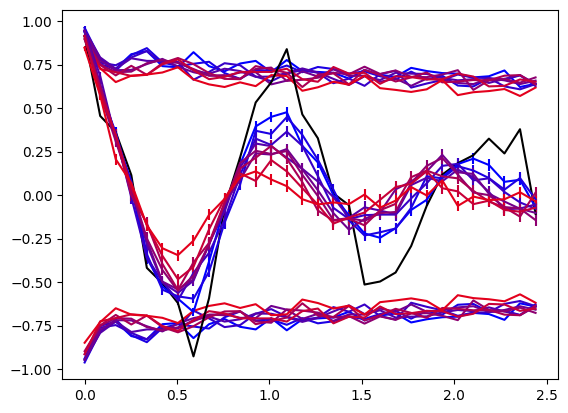

In [22]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
for name_index in range(len(data_names)):
    color = cmap(name_index/len(data_names))
    plt.plot(times, 1-leakage_matrix[:,name_index], label = data_names[name_index], color = color)
    plt.errorbar(times, flopping_matrix[:,name_index], label = data_names[name_index], yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
    plt.plot(times, -1+leakage_matrix[:,name_index], label = data_names[name_index], color = color)
    
#Get ZNed Data:
ZNE_data = np.zeros(30)
for i in range(30):
    fit_func = third_no_first_ZNE(theta_list[:-3], flopping_matrix[i,:-3])
    ZNE_data[i] = fit_func(0)

plt.plot(times, ZNE_data, label = 'ZNE', color = 'black')

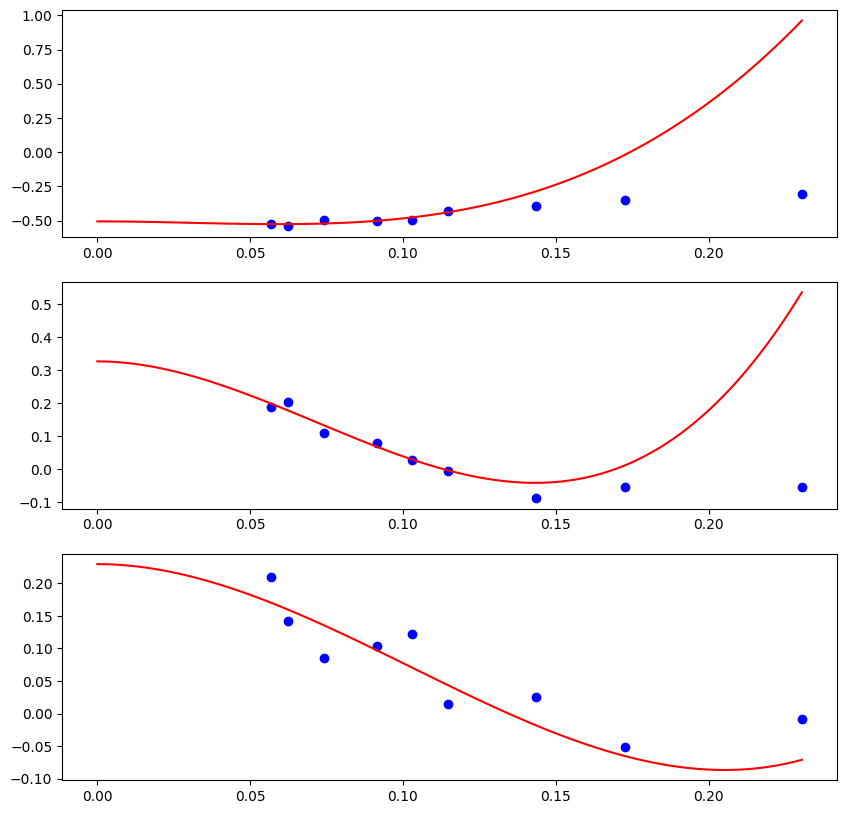

In [23]:
peak_indices = [5,15,25]
#create 3 subplots. at the peak index, plot vs. theta, fit to cubic_no_first, and plot the fit

fig, axes = plt.subplots(3)

for i in range(3):
    axis = axes[i]
    axis.scatter(theta_list, flopping_matrix[peak_indices[i],:], label = 'Data', color = 'blue')
    fit_func = third_no_first_ZNE(theta_list[:-3], flopping_matrix[peak_indices[i],:-3])#, flopping_matrix[peak_indices[i],1], flopping_matrix[peak_indices[i],2], flopping_matrix[peak_indices[i],3])
    dense_theta = np.linspace(0, theta_list[-1], 100)
    axis.plot(dense_theta, fit_func(dense_theta), label = 'Fit', color = 'red')
    #Make the plots bigger:
    
fig.set_size_inches(10, 10)
    
    
    